Implementation on new data with Bubble

In [2]:
import re
import sys
import csv
import time
import json

from unidecode import unidecode

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook
from unidecode import unidecode

from collections import defaultdict
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
source = '/Users/elise/Documents/?/? data/new/product_nuts_with_usage_and_product_id.csv'
#source = 'data/product_nuts_with_usage_and_product_id.csv'

In [4]:
data_pn_usage = []

with open(source) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in tqdm_notebook(readCSV):
        data_pn_usage.append(eval(row[0]))

** Select only those product nuts that have a category ** 

In [5]:
STOPWORDS = '''
    het de deze en of om te hier nog ook al in van voor mee per als tot uit bij waar waardoor waarvan wanneer
    je uw ze zelf jezelf ca bijv bijvoorbeeld is bevat hebben kunnen mogen zullen willen gemaakt aanbevolen
    belangrijk belangrijke heerlijk heerlijke handig handige dagelijks dagelijkse
    gebruik allergieinformatie bijdrage smaak hoeveelheid aan aangaande aangezien achter achterna afgelopen 
    al aldaar aldus alhoewel alias alle allebei alleen alsnog altijd altoos ander andere anders anderszins 
    behalve behoudens beide beiden ben beneden bent bepaald betreffende bij binnen binnenin boven bovenal 
    bovendien bovengenoemd bovenstaand bovenvermeld buiten daar daarheen daarin daarna daarnet daarom daarop 
    daarvanlangs dan dat de die dikwijls dit door doorgaand dus echter eer eerdat eerder eerlang eerst elk elke 
    en enig enigszins enkel er erdoor even eveneens evenwel gauw gedurende geen gehad gekund geleden gelijk 
    gemoeten gemogen geweest gewoon gewoonweg haar had hadden hare heb hebben hebt heeft hem hen het hierbeneden 
    hierboven hij hoe hoewel hun hunne ik ikzelf in inmiddels inzake is jezelf jij jijzelf jou jouw jouwe juist
    jullie kan klaar kon konden krachtens kunnen kunt later liever maar mag meer met mezelf mij mijn mijnent mijner 
    mijzelf misschien mocht mochten moest moesten moet moeten mogen na naar nadat net niet noch nog nogal nu of 
    ofschoon om omdat omhoog omlaag omstreeks omtrent omver onder ondertussen ongeveer ons onszelf onze ook op 
    opnieuw opzij over overeind overigens pas precies reeds rond rondom sedert sinds sindsdien slechts sommige 
    spoedig steeds tamelijk tenzij terwijl thans tijdens toch toen toenmaals toenmalig tot totdat tussen uit 
    uitgezonderd vaak van vandaan vanuit vanwege veeleer verder vervolgens vol volgens voor vooraf vooral 
    vooralsnog voorbij voordat voordezen voordien voorheen voorop vooruit vrij vroeg waar waarom wanneer 
    want waren was wat weer weg wegens wel weldra welk welke wie wiens wier wij wijzelf zal ze zelfs zichzelf 
    zij zijn zijne zo zodra zonder zou zouden zowat zulke zullen zult een  je  te lekker bekende wordt namelijk
'''.split()

def clean(s):
    if s is None: return None
    s = unidecode(s).strip() # removes unicode
    s = re.sub('<[^<]+?>', '', s)
    s = re.sub(r'[^A-Za-z0-9\'\s]', '', s, flags=re.MULTILINE) # removes all non A-Z a-z or numbers
    s = re.sub(r'\s+', ' ', s, flags=re.MULTILINE) # replaces all whitespace with a space
    return s

def f_categories(j):
    if j.get('categories', '') == '': return []
    
    categories = []
    for x in j.get('categories', ''):
        categories.extend(x.split(' '))
        
    categories = [clean(c) for c in categories]
    return categories

def tok(data):
    '''Returns a dict including the tokens, usage and product_id for all products nuts'''
    id_tokens = []
    for j in data:

        tokens = f_categories(j)
        tokens = filter(lambda s: s not in STOPWORDS, tokens)
        tokens = filter(lambda s: len(s) > 1, tokens)
        
        id_tokens.append({'id': j['id'], 'tokens': tokens, 'usage':j['usage'], 'product_id':j['product_id']})
        
    return id_tokens

In [6]:
pn_categories = [x for x in data_pn_usage if x.get('categories', '') != '']
id_tokens_categories = tok(pn_categories)

In [9]:
print len(id_tokens_categories)
print len(data_pn_usage)

177520
493168


- Remove doubles
- Include only those nut products if the usage appears in at least 3 products

In [10]:
# removes doubles
known = set()
no_doubles = []

for d in tqdm_notebook(id_tokens_categories):
    tok = ' '.join(d['tokens'])
    if tok in known: 
        continue
    no_doubles.append(d)
    known.add(tok)

In [11]:
# makes a dict where each tuple has one usage and all the product_ids linked to it
k = [{x['usage']: x['product_id']} for x in no_doubles]
dd = defaultdict(list)

for d in tqdm_notebook(k): 
    for key, value in d.iteritems():
        dd[key].append(value)

In [12]:
# checks if a usage is linked to at least 3 products
allowed_usage = []
for x in tqdm_notebook(dd.items()):
    if len(set(x[1])) > 2:
        allowed_usage.append(x[0])
        
set_allowed_usage = set(allowed_usage)

complete = []
for x in tqdm_notebook(no_doubles):
    if x['usage'] in set_allowed_usage:
        complete.append(x)

LABELS

In [13]:
labels = [x['product_id'] for x in complete]

In [14]:
K_fold = int(len(set(labels)) / 6)

one = set(list(set(labels))[:K_fold])
two = set(list(set(labels))[K_fold:(K_fold * 2)])
three = set(list(set(labels))[(2 * K_fold):(K_fold * 3)])
four = set(list(set(labels))[(3 * K_fold):(K_fold * 4)])
five = set(list(set(labels))[(4 * K_fold):(K_fold * 5)])
six = set(list(set(labels))[(5 * K_fold):])

labels_6 = []
for label in tqdm_notebook(labels):
    if label in one:
        labels_6.append(1)
    elif label in two:
        labels_6.append(2)
    elif label in three:
        labels_6.append(3)
    elif label in four:
        labels_6.append(4)
    elif label in five:
        labels_6.append(5)
    elif label in six:
        labels_6.append(6)

X

In [15]:
text_per_item_pn_TRAIN = [' '.join(tokens['tokens']) for tokens in complete if tokens['product_id'] not in six]
text_per_item_pn_VALIDATE = [' '.join(tokens['tokens']) for tokens in complete if tokens['product_id'] in six]

In [16]:
vectorizer = CountVectorizer(min_df=1, binary=True)
X_TRAIN = vectorizer.fit_transform(text_per_item_pn_TRAIN)

In [17]:
vocab = vectorizer.vocabulary_
vectorizer = CountVectorizer(min_df=1, vocabulary=vocab)
X_VALIDATE = vectorizer.fit_transform(text_per_item_pn_VALIDATE)

Y

In [18]:
Y_TRAIN = [x['usage'] for x in complete if x['product_id'] not in six]
Y_VALIDATE = [x['usage'] for x in complete if x['product_id'] in six]

In [19]:
labels_TRAIN = []
for x in enumerate(labels_6):
    if x[1] != 6:
        labels_TRAIN.append(x[1])

In [20]:
print 'X: ', X_VALIDATE.shape, 'Y: ', len(Y_VALIDATE)
print 'X: ', X_TRAIN.shape, 'Y: ',len(Y_TRAIN), 'Labels: ', len(labels_TRAIN)

X:  (733, 2524) Y:  733
X:  (3679, 2524) Y:  3679 Labels:  3679


Cross_Validation

In [21]:
cv = LeaveOneLabelOut(labels_TRAIN)

clf = LinearSVC(random_state = 2, verbose = 1)
scores = cross_val_score(clf, X_TRAIN, Y_TRAIN, cv=cv, scoring='accuracy')

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [22]:
print "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

Accuracy: 0.48 (+/- 0.03)


** Feature Reduction **

In [23]:
def compute_scores(X, Y, labels):
    cv = LeaveOneLabelOut(labels_TRAIN)
    clf = LinearSVC(random_state = 2, verbose = 1, max_iter=200000)
    scores = cross_val_score(clf, X, Y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    return scores

In [24]:
TRAIN = []
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for precentage in percentages:
    TRAIN.append([precentage, SelectPercentile(percentile=precentage).fit_transform(X_TRAIN, Y_TRAIN)])

In [25]:
scores = []
for train_x in tqdm_notebook(TRAIN):
    scores.append([train_x[0], compute_scores(train_x[1], Y_TRAIN, labels_TRAIN)])

In [26]:
for score in scores:
    print "Accuracy Linear SVC " + str(score[0]) + ": %0.2f (+/- %0.2f)" % (score[1].mean(), score[1].std() * 2)

Accuracy Linear SVC 10: 0.36 (+/- 0.04)
Accuracy Linear SVC 20: 0.46 (+/- 0.03)
Accuracy Linear SVC 30: 0.48 (+/- 0.03)
Accuracy Linear SVC 40: 0.49 (+/- 0.02)
Accuracy Linear SVC 50: 0.48 (+/- 0.03)
Accuracy Linear SVC 60: 0.48 (+/- 0.03)
Accuracy Linear SVC 70: 0.48 (+/- 0.02)
Accuracy Linear SVC 80: 0.48 (+/- 0.03)
Accuracy Linear SVC 90: 0.48 (+/- 0.03)
Accuracy Linear SVC 100: 0.48 (+/- 0.03)


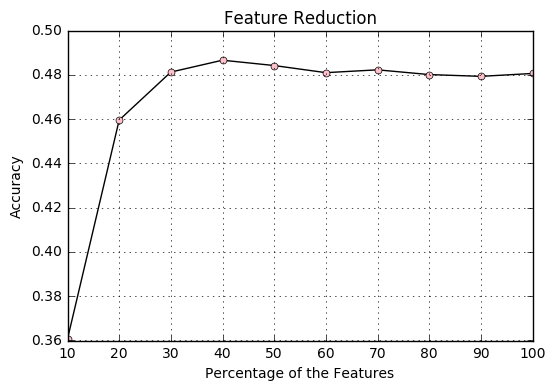

In [36]:
import matplotlib.pyplot as plt
plt.title('Feature Reduction')
plt.xlabel('Percentage of the Features')
plt.ylabel('Accuracy')
plt.grid(True)

x = np.array([score[0] for score in scores])
y = np.array([score[1].mean() for score in scores])

plt.plot(x, y, color='black', marker='o', linestyle='-', markerfacecolor='pink', markersize=5)
plt.savefig('feature_reduction_categories_2.png')
plt.show()

** Check what is removed **

In [27]:
reduced = SelectPercentile(percentile=4)
reduced.fit(X_TRAIN, Y_TRAIN)
list_of_features = reduced.get_support()

In [28]:
index_removed = []
for x in enumerate(list_of_features):
    if x[1] != True:
        index_removed.append(x[0])

In [29]:
flipped_vocab = {v: k for k, v in vocab.iteritems()}

In [30]:
list_removed = []
for n in index_removed:
    list_removed.append(flipped_vocab[n])

In [31]:
# 99 procent - 1% best
set(vocab.keys()) - set(list_removed)

{u'aardappelproducten',
 u'aardappelsalade',
 u'aioli',
 u'appels',
 u'atjar',
 u'aubergine',
 u'bapao',
 u'beef',
 u'bier',
 u'blauwaderkaas',
 u'bloemen',
 u'boerenkool',
 u'bruintint',
 u'cashewnoten',
 u'cassis',
 u'cervelaat',
 u'champignons',
 u'cheese',
 u'chickenburger',
 u'chocoladepasta',
 u'cola',
 u'corned',
 u'dadels',
 u'dameshygiene',
 u'diksap',
 u'drogisterij',
 u'druiven',
 u'eieren',
 u'energiedranken',
 u'fazant',
 u'fricandeau',
 u'frituurvet',
 u'grillworst',
 u'hazelnoot',
 u'ijs',
 u'ijstaarten',
 u'kalfsvlees',
 u'kappertjes',
 u'kauwgom',
 u'ketchup',
 u'knoflooksaus',
 u'kokoswater',
 u'konijn',
 u'kookworst',
 u'koolvis',
 u'koreaans',
 u'koreaanse',
 u'kroepoek',
 u'lamsvlees',
 u'macaroni',
 u'makreel',
 u'meloen',
 u'meloenen',
 u'mondwater',
 u'olie',
 u'onion',
 u'ontbijtkoek',
 u'opvolgmelk',
 u'paddestoelen',
 u'paneermeel',
 u'paprikapoeder',
 u'parmezaanse',
 u'pecannoten',
 u'penne',
 u'peren',
 u'perziken',
 u'planten',
 u'pompoensoep',
 u'quiches

In [32]:
print 'suiker' in list_removed
print 'zout' in list_removed

True
True


** Validate **

In [114]:
clf.fit(X_TRAIN, Y_TRAIN)
predictions = clf.predict(X_VALIDATE)

[LibLinear]

In [115]:
def classifaction_report_csv(report):
    report_data = []
    lines = report.encode('ascii', 'ignore').split('\n')
    for line in (lines[2:-3] + [lines[-2]]):
        row = {}
        row_data = line.strip().split('  ')
        row_data = [x for x in row_data if x != '']
        row['class'] = row_data[0]
        row['precision'] = row_data[1]
        row['recall'] = row_data[2]
        row['f1_score'] = row_data[3]
        row['support'] = row_data[4]
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    #dataframe.to_csv('classification_report.csv', index = False)
    return dataframe

report = classification_report(Y_VALIDATE, predictions)
df = classifaction_report_csv(report)

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [118]:
print 'micro recall score: ',recall_score(Y_VALIDATE, predictions, average = 'micro')

micro recall score:  0.770644335892


- Reliable Recall Macro Score

In [117]:
report_data = []
lines = report.encode('ascii', 'ignore').split('\n')
for line in (lines[2:-3] + [lines[-2]]):
    row = {}
    row_data = line.strip().split('  ')
    row_data = [x for x in row_data if x != '']
    row['class'] = row_data[0]
    row['precision'] = row_data[1]
    row['recall'] = row_data[2]
    row['f1_score'] = row_data[3]
    row['support'] = row_data[4]
    report_data.append(row)
    
recall = []
for d in report_data:
    if d['support'].strip() != '0':
        recall.append(d['recall'])
        
n_recall = [float(x) for x in recall]
print 'macro recall score: ',sum(n_recall) / len(recall)

macro recall score:  0.603302387268
